# MNIST database handwritten digit recognition using machine learning.

In this exercise, we will learn to recognize handwritten digits using python, numpy and tensorflow

## Importing necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-06-21 05:30:23.968910: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Functions to read data

### Read the MNIST image file
The file format is
- First four bytes - a magic number = 2051, to make sure the file is downloaded properly
- Next four bytes - number of images
- Next four bytes - number of rows in each image
- Next four bytes - number of columns in each image
- Rest of the bytes - the images themselves.

The catch is that, the file is stored in Big Endian format. Click [here](https://en.wikipedia.org/wiki/Endianness) to learn more.

In [2]:
def read_mnist_images(filename):
    with open(filename, "rb") as f:
        magic_number = int.from_bytes(f.read(4), byteorder="big")
        if magic_number != 2051:
            raise ValueError("Magic number invalid, check the downloaded files")
        num_images = int.from_bytes(f.read(4), byteorder="big")
        num_rows = int.from_bytes(f.read(4), byteorder="big")
        num_cols = int.from_bytes(f.read(4), byteorder="big")
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape(num_images, num_rows, num_cols)
    return images    

### Read the MNIST label file
The file format is
- First four bytes - a magic number = 2049, to make sure the file is downloaded properly
- Next four bytes - the number of labels
- Rest of the bytes - the labels themselves.

Here, again the file is stored in Big Endian format.

In [3]:
def read_mnist_labels(filename):
    with open(filename, "rb") as f:
        magic_number = int.from_bytes(f.read(4), byteorder="big")
        if magic_number != 2049:
            raise ValueError("Magic number invalid, check the downloaded files")
        num_labels = int.from_bytes(f.read(4), byteorder="big")
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

### Read the data into python

In [4]:
def read_data():
    train_images = read_mnist_images("data/train-images.idx3-ubyte")
    train_labels = read_mnist_labels("data/train-labels.idx1-ubyte")
    test_images = read_mnist_images("data/test-images.idx3-ubyte")
    test_labels = read_mnist_labels("data/test-labels.idx1-ubyte")
    return train_images, train_labels, test_images, test_labels

#### Check the shapes to make sure everything is read properly

In [5]:
train_images, train_labels, test_images, test_labels = read_data()
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


## Preview the images and their labels

Label: 5


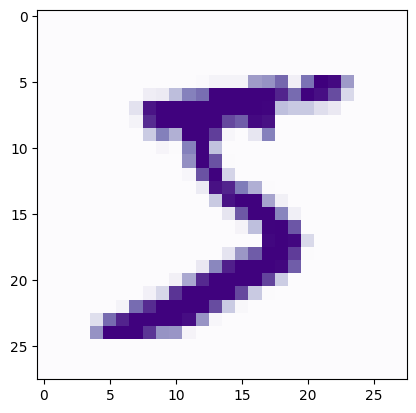

In [6]:
# preview the 0th image
image_id1 = 0
plt.imshow(train_images[image_id1], cmap="Purples")
print(f"Label: {train_labels[image_id1]}")

Label: 0


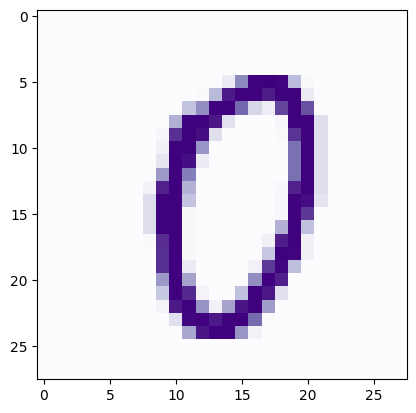

In [7]:
# preview 1000th image
image_id2 = 1000
plt.imshow(train_images[image_id2], cmap="Purples")
print(f"Label: {train_labels[image_id2]}")

The preview images and labels match. Now, we are sure the images are properly loaded into memory

## Preprocessing

## Normalization of the image data

Machine learning works best if the data is in the 0-1 range (better application of loss functions). The images are in the 0-255 range, we want them in 0-1 range. So we divide the values by 255

In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Even after normalization, no data is changed or destroyed. This can be seen with a preview of the same two images above. 

Text(0.5, 1.0, 'Image 2')

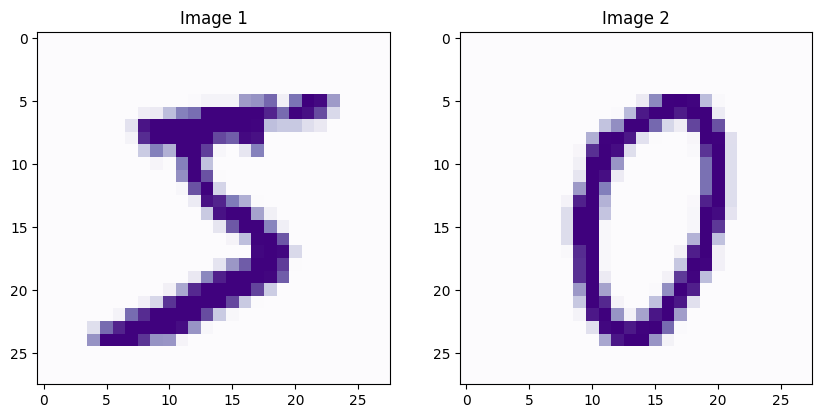

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# First image
axes[0].imshow(train_images[image_id1], cmap="Purples")
axes[0].set_title('Image 1')

# Second image
axes[1].imshow(train_images[image_id2], cmap="Purples")
axes[1].set_title('Image 2')

### One hot encoding for labels
The labels are of the shape (60000,). That means, it is a list of 60000 numbers for 60000 images. Each image has an integer as it's label. But in machine learning, we deal with probabilities and we need something like 

- 0 = \[1, 0, 0, 0, 0, 0, 0, 0, 0, 0\]
- 1 = \[0, 1, 0, 0, 0, 0, 0, 0, 0, 0\]
- 2 = \[0, 0, 1, 0, 0, 0, 0, 0, 0, 0\]
- 3 = \[0, 0, 0, 1, 0, 0, 0, 0, 0, 0\]
- 4 = \[0, 0, 0, 0, 1, 0, 0, 0, 0, 0\]
- 5 = \[0, 0, 0, 0, 0, 1, 0, 0, 0, 0\]
- 6 = \[0, 0, 0, 0, 0, 0, 1, 0, 0, 0\]
- 7 = \[0, 0, 0, 0, 0, 0, 0, 1, 0, 0\]
- 8 = \[0, 0, 0, 0, 0, 0, 0, 0, 1, 0\]
- 9 = \[0, 0, 0, 0, 0, 0, 0, 0, 0, 1\]

This method of encoding the nth index of the number as "1" and rest of the digits as "0" is called one hot encoding. 

In [10]:
def get_onehot_encoding(matrix):
    return np.eye(matrix.max()+1)[matrix]

In [11]:
train_labels_one_hot = get_onehot_encoding(train_labels)
test_labels_one_hot = get_onehot_encoding(test_labels)

In [12]:
train_labels_one_hot[image_id1]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

See that the 5th index is 1 and rest are 0

In [13]:
train_labels_one_hot[image_id2]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

See that the 0th element is 1 and rest are 0. 

## Feed the data into tensorflow

In [14]:
train = tf.data.Dataset.from_tensor_slices((train_images, train_labels_one_hot)).batch(100)
test = tf.data.Dataset.from_tensor_slices((test_images, test_labels_one_hot)).batch(100)

Notice the chained batch call at the end. Tensorflow can make the data into batches for faster processing and better calculation of losses.

## Machine learning

### Construct the machine learning model

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax") # Softmax activation to get probabilities (like one hot encoding, which is our output)
])

### Prepare the model for training by selecting the optimizer and loss functions

In [16]:
model.compile(optimizer="adam", loss="mae")

### Train the model for 10 epochs

In [17]:
model.fit(train, epochs=10, validation_data=test)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0554 - val_loss: 0.0151
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0134 - val_loss: 0.0111
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - loss: 0.0099 - val_loss: 0.0099
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 953us/step - loss: 0.0083 - val_loss: 0.0085
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step - loss: 0.0073 - val_loss: 0.0079
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - loss: 0.0065 - val_loss: 0.0073
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - loss: 0.0056 - val_loss: 0.0081
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - loss: 0.0052 - val_loss: 0.0063
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step - loss: 0.0049 - val_loss: 0.0065
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step - loss: 0.0043 - val_loss: 0.0063


### Try predicting the images we previewed earlier

In [18]:
result1 = model.predict(train_images[image_id1].reshape(1, 28, 28))[0]
result1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([2.55780674e-24, 2.65532146e-22, 3.27898180e-16, 7.90020067e-07,
       1.06919485e-36, 9.99999166e-01, 2.54583394e-31, 7.18680289e-24,
       3.59199333e-25, 1.05517647e-19], dtype=float32)

Notice that the 6th element is having the highest value (0.99). This says that the result is a one hot encoding of \[0, 0, 0, 0, 0, 1, 0, 0, 0, 0\], which means the output is 5. 

In [19]:
result1_digit = np.argmax(result1)
result1_digit

5

In [20]:
result2 = model.predict(train_images[image_id2].reshape(1, 28, 28))[0]
result2_digit = np.argmax(result2)
result2_digit

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


0

## Save our machine learning model to the hard disk for future use

In [21]:
model.save("model.keras")